In [1]:
import flowshape as fs
import igl
import numpy as np
import meshplot as mp
import os
import pandas as pd
from src.utilities.fin_shape_utils import plot_mesh
from src.utilities.fin_class_def import FinData
from src.utilities.functions import path_leaf
import glob2 as glob
import meshplot as mp
import trimesh

## Hashing out preprocessing steps prior to SH analysis

### Load fin data

In [8]:
# get list of refined fin mesh objects
root = "/media/nick/hdd02/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/pecfin_dynamics/"

fin_mesh_list = sorted(glob.glob(os.path.join(root, "point_cloud_data", "processed_fin_data", "*smoothed_fin_mesh*")))
# raw_mesh_list = sorted(glob.glob(os.path.join(root, "point_cloud_data", "processed_fin_data", "*raw_fin_mesh*")))
# fin_df_list = sorted(glob.glob(os.path.join(root, "point_cloud_data", "processed_fin_data", "*upsampled*")))
# fin_df_c_list = sorted(glob.glob(os.path.join(root, "point_cloud_data", "processed_fin_data", "*data.csv")))

In [9]:
ref_ind = 8 # ra-treated 48 hpf
target_ind = 5 

mesh_ref =trimesh.load(fin_mesh_list[ref_ind])
mesh_target =trimesh.load(fin_mesh_list[target_ind])
# raw_fin_mesh =trimesh.load(raw_mesh_list[file_ind])
# fin_df = pd.read_csv(fin_df_list[file_ind])
# fin_df_c = pd.read_csv(fin_df_c_list[file_ind])

# print(fin_df_c_list[file_ind])

### Normalize and align

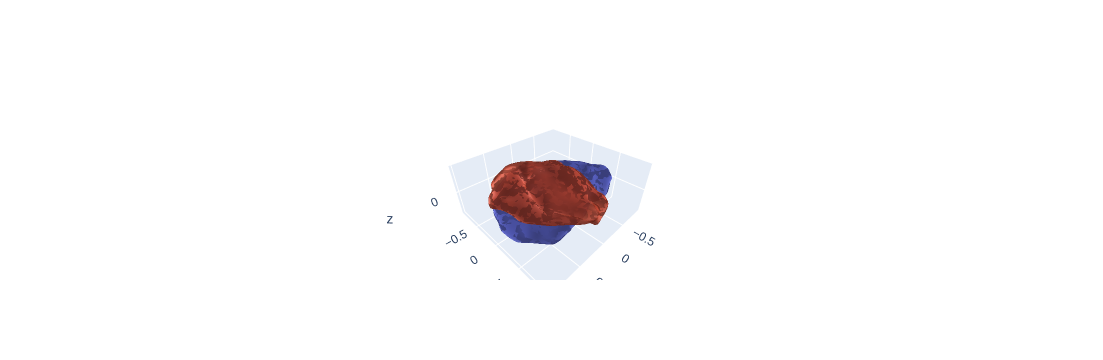

In [59]:
import plotly.graph_objects as go

v_ref = mesh_ref.vertices.copy()
v_target = mesh_target.vertices.copy()

# normalize the scaling of the mesh
v_ref_norm = fs.normalize(v_ref.copy())
v_target_norm = fs.normalize(v_target.copy())

# update meshes
mesh_ref_norm = mesh_ref.copy()
mesh_ref_norm.vertices = v_ref_norm
mesh_src_norm = mesh_target.copy()
mesh_src_norm.vertices = v_target_norm

_, _, rm = plot_mesh(mesh_ref_norm, surf_alpha=0.75)
_, _, tm = plot_mesh(mesh_src_norm, surf_alpha=0.75)

fig = go.Figure()
fig.add_trace(rm)
fig.add_trace(tm)
fig.show()

### Sample points from surfaces and fit a rotation matrix

In [60]:
np.random.seed(455)

n_ref_points = 1000
ref_points = mesh_ref_norm.sample(count=n_ref_points)
source_points = mesh_target_norm.sample(count=n_ref_points)

In [61]:
from scipy.spatial import KDTree

tree = KDTree(ref_points[:500, :])
dist, ind = tree.query(source_points)

dist.shape

(1000,)

In [62]:
import numpy as np
from scipy.spatial.transform import Rotation as R
from scipy.optimize import minimize
from scipy.optimize import least_squares

def constrained_align_point_clouds(source, target, theta_max=np.pi/6, phi_max=np.pi/6):
    """
    Aligns source to target with constrained rotation angles.
    Args:
        source: Nx3 array of source points.
        target: Nx3 array of target points.
        theta_max: Maximum allowed rotation angle (radians) for elevation.
        phi_max: Maximum allowed rotation angle (radians) for azimuth.
    Returns:
        optimal_rotation_matrix: 3x3 optimal rotation matrix.
        optimal_angles: Optimal angles (theta, phi).
    """

    target_tree = KDTree(target)
    
    def cost_function(params):
        # Extract parameters
        theta, phi = params
        # Construct rotation matrix from theta and phi
        rotation = R.from_euler('zx', [phi, theta], degrees=False)
        rotation_matrix = rotation.as_matrix()
        # Rotate source
        rotated_source = source @ rotation_matrix.T
        # find nearest neighbor points
        dist, _ = tree.query(rotated_source)
        # Compute alignment cost (mean squared distance)
        # error = np.mean(dist**2)
        return dist

    # Initial guess for theta and phi
    initial_guess = [0.0, 0.0]

    # Constraints for theta and phi
    bounds = ([-theta_max, -phi_max], [theta_max, phi_max])

    # Minimize cost function
    result = least_squares(cost_function, initial_guess, bounds=bounds)

    # Extract optimal parameters
    optimal_theta, optimal_phi = result.x
    optimal_rotation = R.from_euler('zx', [optimal_phi, optimal_theta], degrees=False)
    optimal_rotation_matrix = optimal_rotation.as_matrix()

    return optimal_rotation_matrix, (optimal_theta, optimal_phi)

In [63]:
# test it out
# dummy_source = ref_points.copy()
theta = 0.2
phi = 0.1
rotation = R.from_euler('zx', [phi, theta], degrees=False)
rotation_matrix = rotation.as_matrix()
dummy_source = source_points @ rotation_matrix.T

rot, params = constrained_align_point_clouds(dummy_source, ref_points, theta_max=np.pi/10, phi_max=np.pi/10)
print(params)

(-0.28479433072953686, 0.3141592650113332)


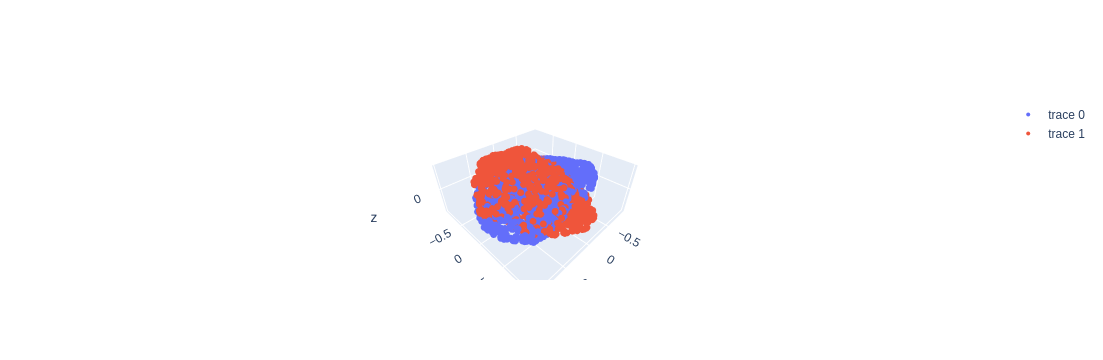

In [64]:
rotated_source = source_points @ rot.T

fig = go.Figure()
fig.add_trace(go.Scatter3d(x=ref_points[:, 0], y=ref_points[:, 1], z=ref_points[:, 2], mode='markers'))
fig.add_trace(go.Scatter3d(x=rotated_source[:, 0], y=rotated_source[:, 1], z=rotated_source[:, 2], mode='markers'))
# fig.add_trace(go.Scatter3d(x=source_points[:, 0], y=source_points[:, 1], z=source_points[:, 2], mode='markers'))
fig.update_traces(marker=dict(size=4))
fig.show()

### This doesn't seem very robust
What about aligning mesh PCAs instead?

In [67]:
from sklearn.decomposition import PCA

pca_ref = PCA(n_components=3)
pca_src = PCA(n_components=3)

pca_ref.fit(mesh_ref_norm.vertices)
pca_src.fit(mesh_src_norm.vertices)

PCA(n_components=3)

In [68]:
print(pca_ref.components_)

[[ 0.99194722  0.11231067 -0.05854078]
 [-0.11140239  0.99360195  0.01856514]
 [ 0.06025129 -0.01189405  0.99811237]]


In [69]:
print(pca_src.components_)

[[ 0.32946457  0.93693061  0.11667963]
 [ 0.9096434  -0.34809683  0.226666  ]
 [-0.25298612 -0.03145844  0.96695832]]


In [45]:
# Y_mat is a matrix used to convert between weights and mesh function
rho2 = Y_mat.dot(weights)
mp.plot(vs,f, c = rho2)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.000142…

### Mesh reconstruction

In [46]:
rec2 = fs.reconstruct_shape(vs, f, rho2 )
mp.plot(rec2,f, c = rho2)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.056183…

### Are SH coefficients scale-invariant?
My expectation is yes

In [50]:
v0, f0 = fin_mesh.vertices.copy(), fin_mesh.faces.copy()
v0_big = v0*100

w0, Y_mat, vs = fs.do_mapping(v0, f0, l_max=15)
w0_big, Y_mat, vs = fs.do_mapping(v0_big, f0, l_max=15)

In [51]:
np.all(np.round(w0, 5) == np.round(w0_big, 5))

True

Yep! We will need an extra scaling coefficient to fully recapitulate the data

### Are SH coefficents rotationally invariant?
Expectation is that they are not

In [53]:
from scipy.spatial.transform import Rotation as R
import numpy as np

# Example point cloud (Nx3 array)
# points = np.random.rand(100, 3)

# Generate a random rotation
rotation = R.random()  # Generates a random 3D rotation
rotation_matrix = rotation.as_matrix()

# Rotate the point cloud
# rotated_points = points @ rotation_matrix.T

v1, f1 = fin_mesh.vertices.copy(), fin_mesh.faces.copy()
v1_rot = v1 @ rotation_matrix.T

w1, _, _ = fs.do_mapping(v1, f1, l_max=15)
w1_rot, _, _ = fs.do_mapping(v1_rot, f1, l_max=15)

np.all(np.round(w1, 5) == np.round(w1_rot, 5))

False

Cool cool cool. 

### Look at recon error

In [77]:
from tqdm import tqdm

v2, f2 = fin_mesh.vertices.copy(), fin_mesh.faces.copy()
# print(np.max(v2))
# # normalize the scaling of the mesh
v2_norm = fs.normalize(v2.copy())

l_vec = np.arange(1, 76, 5)
r2_vec = []
for l in tqdm(l_vec):
    w2, Y2, vs2 = fs.do_mapping(v2_norm, f2, l_max=l)
    rho2 = Y2.dot(w2)
    rec2 = fs.reconstruct_shape(vs2, f2, rho2)

    r2_norm = fs.normalize(rec2.copy())
    

    r2_vec.append(np.sum((v2_norm - r2_norm)**2))

# mp.plot(rec2, f2, c=rho2)

100%|██████████| 15/15 [02:08<00:00,  8.60s/it]


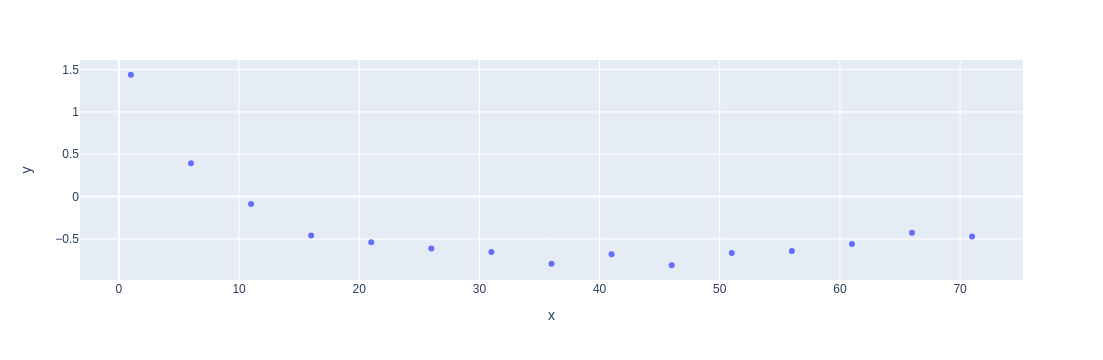

In [82]:
import plotly.express as px

n_factor = np.sum((v2_norm - 0)**2)

fig = px.scatter(x=l_vec, y=np.log10(r2_vec / n_factor * 100))
fig.show()

In [75]:
np.arange(1, 75, 5)

array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71])